# Decision Tree Model and XGBoost

Author: Jindal K. Shah, School of Chemical Engineering, Oklahoma State University

Data Science Workshop, September 20, 2024


In this Google colab, we will use a decision tree and extreme gradient boosting (XGBoost) to models predict the boiling point data for organic compounds. The dataset was acquired from the paper

Journal of Chemical Education, 96(4), 697-703, 2019

*   Import XGBoost package
*   Change the number of boosted trees
*   Plot the score as a function of the number of boosted trees

In [1]:
import numpy as np
from google.colab import files
uploaded = files.upload()


Saving boiling_point_small.csv to boiling_point_small.csv


The above piece of code imports the Numpy library and provides an interface to upload a file from your computer.

In [2]:
import pandas as pd
import io

# read the data as a pandas dataframe
df = pd.read_csv(io.BytesIO(uploaded['boiling_point_small.csv']))


We have uploaded the file boiling_point_small.cvs which contains the data for boiling point of several organic comounds as a function of molecular weight, critical temperature and acentric factor. The formatting of the data is seen below.

In [3]:
# let us look at the data
df.describe()

,molweight,critical temperature (K),acentric factor,boiling point (K)
count,100.000000,100.000000,100.000000,100.000000
mean,157.134262,634.884000,0.521700,448.513700
std,93.589816,118.079564,0.182879,97.891808
min,58.080040,374.180000,0.224000,247.080000
25%,102.165720,569.000000,0.341000,403.000000
50%,134.134998,631.000000,0.508000,436.225000
75%,162.274920,697.150000,0.709250,486.237500
max,547.682640,992.100000,0.844000,693.150000


We can quickly look at the data to see that there are 100 records in the file, the molecular weight varies from 58 to 547 spanning one order of magnitude, while the range of critical temperatures is 374-992 K. On the other hand, the acentric factor varies from 0.224 to 0.844. As can be gleaned from the data, the order of magnitude is similar for the molecular weight and critical temperature while it's two orders of magnitude lower for the acentric factor. Tree-based methods do not require scaling of descriptors; however, if we were using models such as linear regression or neural network, it would be a good idea to scale the descriptors.

## Selection of descriptors and lable
We will use the critical temperature, molecular weight, and acentric factor as the input features while the boiling point will serve as the label. We store the features in *x_features* and the label as *y*

In [6]:
# Form the feature vector and the output vector
x_features = df[['molweight','critical temperature (K)', 'acentric factor']]
y = df['boiling point (K) ']



## Test and Train split
We now split the data in the training set and test set. If you would like to study the influence of the relative proportions of splitting the data adjust the variable *train_size*. *random_state* is fixed at an arbitrary value so that the results are reproducible. Feel free to vary this to see how the output is affected.

*x_train* : features for the training data set

*x_test* : features for the test data set

*y_train*: labels for the training data set

*y_test*: lables for the test data set

In [7]:
# let's start building the model by splitting the data into a train and test data set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_features, y, train_size=0.8,random_state=100)


## Building a decision tree model

We use Scikit-learn library to build a decision tree model, which is stored in *bp_model*. Note that the model *tree_DecisionTreeRegreesor* contains several arguments which can be optimized through cross-validation but we will not attempt to do so in this exercise. For a complete documentation, refer to the link: [Decision Tree Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)

The model is built using the training data set and is used to predict the labels for the training data set, which we will compare with the true labels. Parity plot is a good way to assess how good the model is. Similarly, we make predictions on the test data set.

In [8]:
# start building a decision tree model
from sklearn import tree
import matplotlib.pyplot as plt
# vary the selected parameter
bp_model = tree.DecisionTreeRegressor(min_samples_leaf=5)
# fit the model
bp_model_fit = bp_model.fit(x_train,y_train)

# predict labels for the training data set
y_predict = bp_model_fit.predict(x_train)

# predict labels for the test data set
y_test_predict = bp_model_fit.predict(x_test)




## Parity Plots

Let's plot the predicted labels for the training data set against the true labels.

Text(0.5, 1.0, 'Training Data Set')

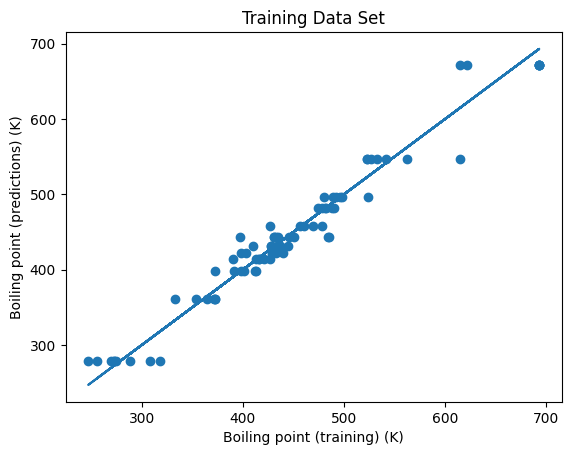

In [9]:
# parity plot for training data set
plt.scatter(y_train,y_predict)
plt.plot(y_train,y_train)
plt.xlabel('Boiling point (training) (K)')
plt.ylabel('Boiling point (predictions) (K)')
plt.title('Training Data Set')

As you can see the model does a pretty good job at capturing the data. One interesting this is that the model predicts the same output for a bunch of points. Look for collections of points that are on the same horizontal line, which implies that This behavior is due to the fact that we set the *min_samples_leaf* to 5. Play with this argument to see how it affects the behavior of the parity plot. We almost never use a single decision tree to make predictions, random forest which averages outputs from a large number of uncorrelated trees is almost always the preferred choice.

In [10]:
this_score = bp_model.score(x_train,y_train)
print("The score of the model %8.3f "  % (this_score))

The score of the model    0.959 


Text(0.5, 1.0, 'Test Data Set')

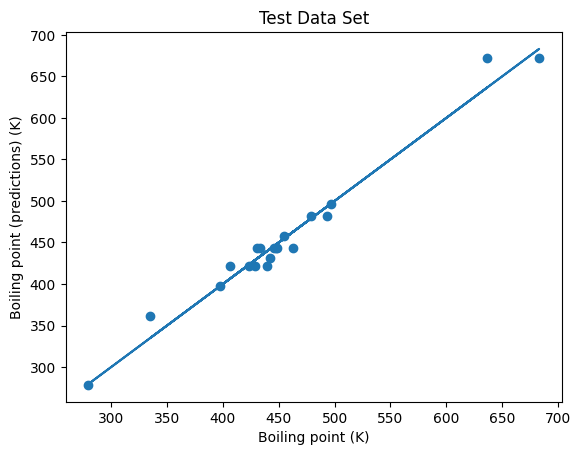

In [11]:
# parity plot for test data set
plt.scatter(y_test,y_test_predict)
plt.plot(y_test,y_test)
plt.xlabel('Boiling point (K)')
plt.ylabel('Boiling point (predictions) (K)')
plt.title('Test Data Set')

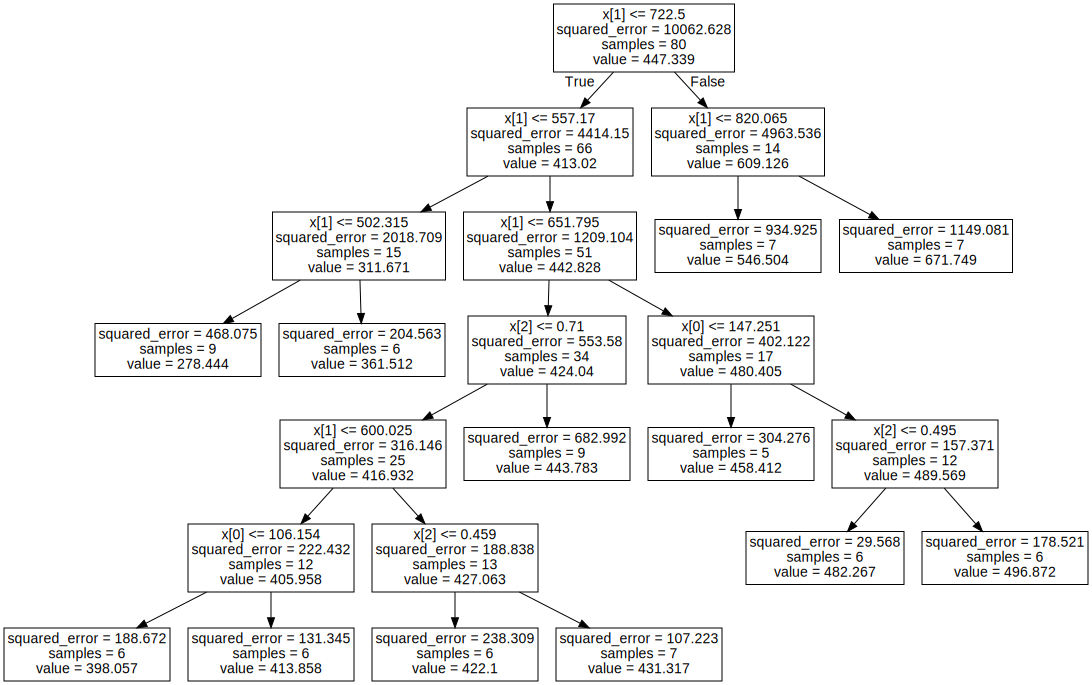

In [12]:
# we want to visualize the tree

import graphviz
dot_data = tree.export_graphviz(bp_model_fit,out_file=None)
graph = graphviz.Source(dot_data)
graph

In the above tree

X[0]: Molecular weight

X[1]: Critical temperature (K)

X[2]: acentric factor

We see that the root node corresponds to X[1] which is the critical temperature for a given molecule. Following the left-most branch, it is evident that when the critical temperature is less than 502.315 K (there are nine compounds) that satisfy this criteria, their boiling points are predicted to be 278.444 K. You are encouraged to identify these compounds and ensure that the average boiling points is 278.444 K!. On the other hand, if the critical temperature is between 502.315 and 557.17 K - the condition which is satisfied for six compunds - the boiling point is predicted to be 361.512 K. This is the power of decision tree models that they are easily interpretable.




# XGBoost

Let's import the model and query the regressor.

In [13]:
from xgboost import XGBRegressor
XGBRegressor?

We will vary the number of trees that we want to develop from 1 to 10 to show the variation in the performance of the model.

In [14]:
n_boosted_trees = 10
train_score = np.zeros((n_boosted_trees,))
test_score = np.zeros((n_boosted_trees,))

for i in range(1,n_boosted_trees+1):
  xgb_model = XGBRegressor(n_estimators=i)
  xgb_model.fit(x_train,y_train)
  print('Number of estimators is %d and score %8.3f'
        % (i, xgb_model.score(x_train,y_train)))
  train_score[i-1] = xgb_model.score(x_train,y_train)
  test_score[i-1] = xgb_model.score(x_test,y_test)



Number of estimators is 1 and score    0.444
Number of estimators is 2 and score    0.689
Number of estimators is 3 and score    0.825
Number of estimators is 4 and score    0.900
Number of estimators is 5 and score    0.941
Number of estimators is 6 and score    0.966
Number of estimators is 7 and score    0.979
Number of estimators is 8 and score    0.987
Number of estimators is 9 and score    0.991
Number of estimators is 10 and score    0.994


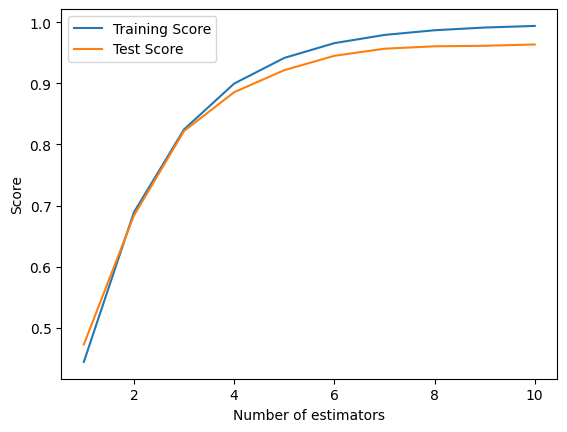

In [15]:
plt.plot(np.arange(1,11),train_score,label='Training Score')
plt.plot(np.arange(1,11),test_score,label='Test Score')
plt.xlabel('Number of estimators')
plt.ylabel('Score')
plt.legend()


We can also evaluate which feature(s) is(are) important. Please note that we are using the model corresponding to 10 boosted trees.

In [16]:
# feature importance
# Corresponds to n_estimators = 10
xgb_model.feature_importances_

array([0.01104296, 0.93534905, 0.053608  ], dtype=float32)

The second feature (critical temperature) is carries the most weight, which is consistent with our observation that the root node contains this feature (though not always necessary).